In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['FG_CO2', 'FG_ALT_CO2', 'POC_FLUX_100m']

In [4]:
experiment = 'historical'
ds_expr = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment)
print(ds_expr)
ds_expr_ann = esmlab_wrap.compute_ann_mean(ds_expr)
print(ds_expr_ann)

<xarray.Dataset>
Dimensions:        (d2: 2, ensemble: 11, region: 4, time: 1980)
Coordinates:
  * time           (time) object 1850-01-16 13:00:00 ... 2014-12-16 12:00:00
  * region         (region) object 'Global' 'SH_mid_lat' 'low_lat' 'NH_mid_lat'
Dimensions without coordinates: d2, ensemble
Data variables:
    time_bound     (time, d2) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    FG_CO2         (time, region, ensemble) float32 -0.26026508 ... 1.7174109
    FG_ALT_CO2     (time, region, ensemble) float32 -0.17487736 ... 1.0317737
    POC_FLUX_100m  (time, region, ensemble) float32 6.968495 ... 0.5502029
Attributes:
    title:             b.e21.BHIST.f09_g17.CMIP6-historical.001
    history:           created by /gpfs/fs1/work/klindsay/analysis/CESM2_coup...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Va

In [5]:
# load Dataset for corresponding experiment_ctrl
experiment_ctrl = data_catalog.find_in_index(experiment=experiment).ctrl_experiment.unique()[0]
print(experiment_ctrl)
ds_ctrl = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment_ctrl)
print(ds_ctrl)
ds_ctrl_ann = esmlab_wrap.compute_ann_mean(ds_ctrl)
print(ds_ctrl_ann)

piControl
<xarray.Dataset>
Dimensions:        (d2: 2, region: 4, time: 14400)
Coordinates:
  * time           (time) object 0001-01-16 12:59:59 ... 1200-12-16 12:00:00
  * region         (region) object 'Global' 'SH_mid_lat' 'low_lat' 'NH_mid_lat'
Dimensions without coordinates: d2
Data variables:
    FG_CO2         (time, region) float32 -0.5303693 -0.27880278 ... 0.81035095
    time_bound     (time, d2) object 0001-01-01 01:59:59 ... 1201-01-01 00:00:00
    FG_ALT_CO2     (time, region) float32 nan nan nan ... -0.9022842 0.81035095
    POC_FLUX_100m  (time, region) float32 nan nan nan ... 3.0691836 0.5971646
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           created by /glade/work/klindsay/analysis/CESM2_coup_ca...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables

In [6]:
# add FG_ANTH_CO2 to datasets
for ds in [ds_expr_ann, ds_ctrl_ann]:
    ds['FG_ANTH_CO2'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
print(ds_expr_ann)
print(ds_ctrl_ann)
varnames.append('FG_ANTH_CO2')

<xarray.Dataset>
Dimensions:        (d2: 2, ensemble: 11, region: 4, time: 165)
Coordinates:
  * region         (region) object 'Global' 'SH_mid_lat' 'low_lat' 'NH_mid_lat'
  * time           (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
Dimensions without coordinates: d2, ensemble
Data variables:
    time_bound     (d2, time) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    FG_CO2         (time, region, ensemble) float64 -0.09321 -0.1424 ... 1.315
    FG_ALT_CO2     (time, region, ensemble) float64 -0.03564 -0.08486 ... 0.7187
    POC_FLUX_100m  (time, region, ensemble) float64 6.852 7.198 ... 1.834 1.807
    FG_ANTH_CO2    (time, region, ensemble) float64 -0.05757 -0.05749 ... 0.5961
Attributes:
    history:  \n2019-06-09 07:43:22.109411 esmlab.resample(<DATASET>, freq="a...
<xarray.Dataset>
Dimensions:        (d2: 2, region: 4, time: 1200)
Coordinates:
  * region         (region) object 'Global' 'SH_mid_lat' 'low_lat' 'NH_mid_lat'
  * time           (time) object 0

In [7]:
# construct year range of experiment_ctrl to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).ctrl_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0451-01-01', '1086-01-01')


In [8]:
# compute experiment_ctrl mean, for detrending
ds_ctrl_ann_slice_mean = ds_ctrl_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_ctrl_ann_slice_mean)

<xarray.Dataset>
Dimensions:        (region: 4)
Coordinates:
  * region         (region) object 'Global' 'SH_mid_lat' 'low_lat' 'NH_mid_lat'
Data variables:
    FG_CO2         (region) float64 -0.04369 0.3379 -1.007 0.625
    FG_ALT_CO2     (region) float64 -0.04369 0.3379 -1.007 0.625
    POC_FLUX_100m  (region) float64 7.002 2.284 2.883 1.835
    FG_ANTH_CO2    (region) float64 -2.136e-13 -4.983e-13 0.0 -7.715e-12
Attributes:
    history:  \n2019-06-09 07:43:47.711408 esmlab.resample(<DATASET>, freq="a...


In [9]:
ds_expr_ann_detrended = ds_expr_ann - ds_ctrl_ann_slice_mean

In [10]:
# add cummulate flux vars to datasets
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

print(ds_expr_ann)
print(ds_expr_ann_detrended)

<xarray.Dataset>
Dimensions:            (d2: 2, ensemble: 11, region: 4, time: 165)
Coordinates:
  * region             (region) object 'Global' 'SH_mid_lat' ... 'NH_mid_lat'
  * time               (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
Dimensions without coordinates: d2, ensemble
Data variables:
    time_bound         (d2, time) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    FG_CO2             (time, region, ensemble) float64 -0.09321 ... 1.315
    FG_ALT_CO2         (time, region, ensemble) float64 -0.03564 ... 0.7187
    POC_FLUX_100m      (time, region, ensemble) float64 6.852 7.198 ... 1.807
    FG_ANTH_CO2        (time, region, ensemble) float64 -0.05757 ... 0.5961
    FG_CO2_CUM         (time, region, ensemble) float64 -0.09321 ... 141.6
    FG_ALT_CO2_CUM     (time, region, ensemble) float64 -0.03564 ... 106.9
    POC_FLUX_100m_CUM  (time, region, ensemble) float64 6.852 7.198 ... 304.2
    FG_ANTH_CO2_CUM    (time, region, ensemble) float64 -0.05757 

array([129.00083804, 128.35837076, 126.25672323, 129.25367957,
       127.98229684, 129.72096299, 127.18066853, 127.09154996,
       128.71135946, 126.31796698, 126.13093454])

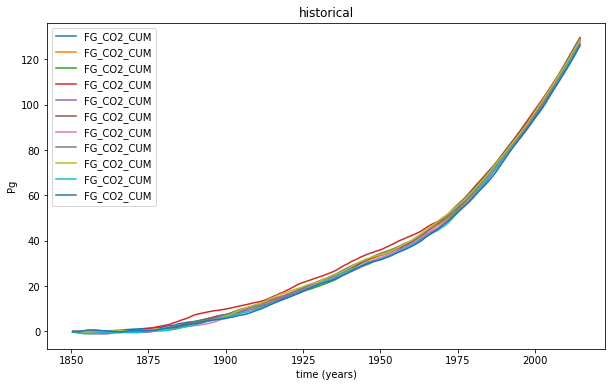

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([131.64589092, 131.65274467, 131.98705905, 131.66435376,
       131.73019788, 131.76119662, 131.71994455, 131.89967521,
       131.49691348, 131.66404959, 131.81255915])

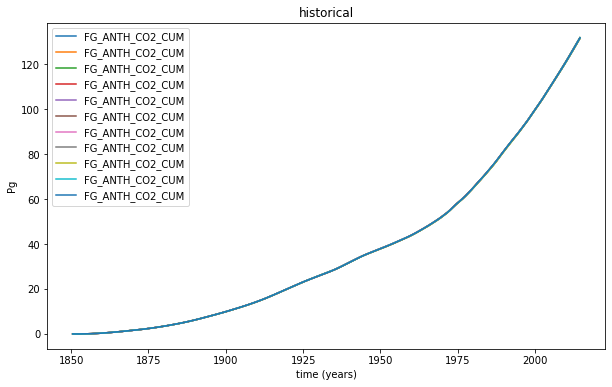

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([136.20904969, 135.56658241, 133.46493488, 136.46189122,
       135.19050848, 136.92917464, 134.38888018, 134.2997616 ,
       135.91957111, 133.52617863, 133.33914619])

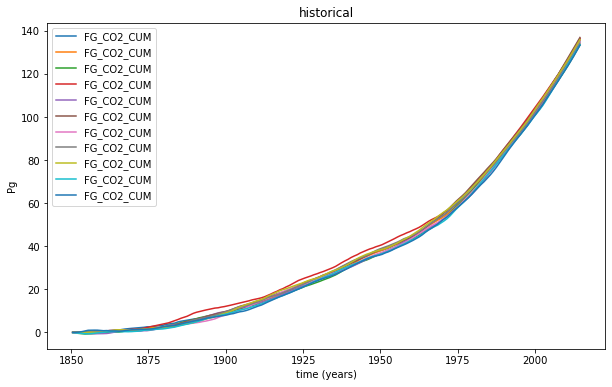

In [13]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([131.64589092, 131.65274467, 131.98705905, 131.66435376,
       131.73019788, 131.76119662, 131.71994455, 131.89967521,
       131.49691348, 131.66404959, 131.81255915])

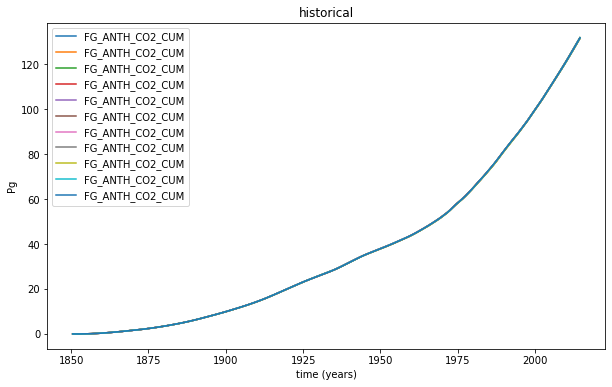

In [14]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([4.56315876, 3.91383775, 1.47787583, 4.79753746, 3.4603106 ,
       5.16797802, 2.66893564, 2.40008639, 4.42265763, 1.86212904,
       1.52658705])

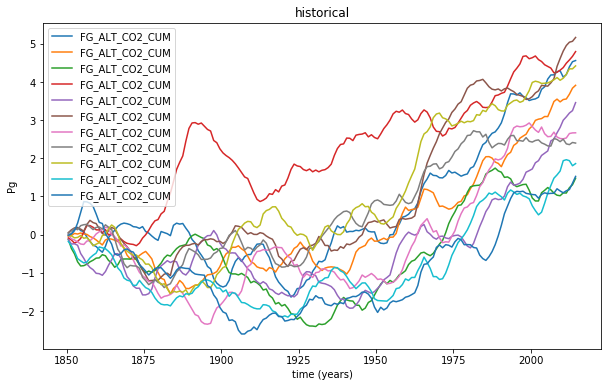

In [15]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([-2.64505288, -3.2943739 , -5.73033582, -2.41067419, -3.74790105,
       -2.04023363, -4.53927601, -4.80812525, -2.78555402, -5.34608261,
       -5.6816246 ])

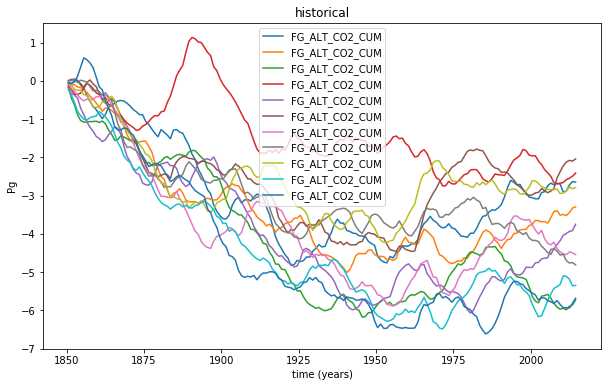

In [16]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

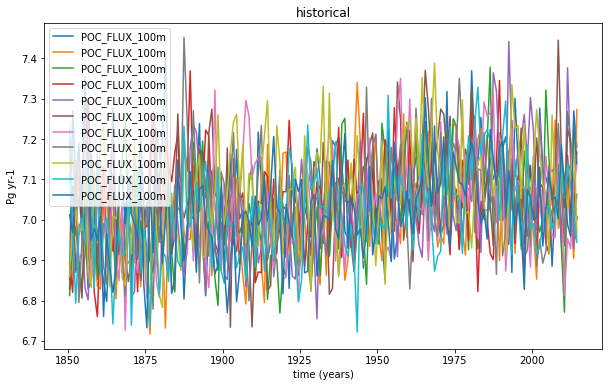

In [17]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['POC_FLUX_100m'], title=experiment, region_val='Global')

array([ 6.87146439,  1.41763012,  4.00410916,  7.18928378,  5.63133211,
        7.08643284,  5.60834575,  6.91247335, 10.23639591,  2.38337835,
        3.56695371])

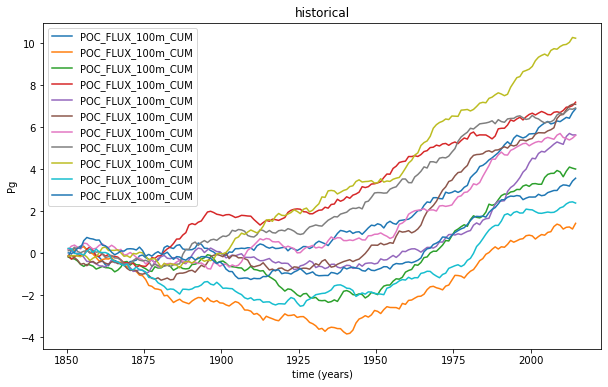

In [18]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['POC_FLUX_100m_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['POC_FLUX_100m_CUM'].sel(region='Global').isel(time=-1).values